# VC Project 2

## Imports

In [ ]:
import cv2
import numpy as np
np.random.seed(42)
import ast
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from mnist import MNIST
import warnings
from IPython.display import display, Image
import os
import json
import sys
import torch
from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

# ======================== Suppress Warnings ========================

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

DRIVE_ROOT_DIR = ""

: 

In [2]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Defining functions

In [2]:
def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names

def loadImage(num, imgLoadSizeRatio = 1, dataDir = 'data/imgs', standardSize = -1):
    img = cv2.imread(os.path.join(dataDir, f'{num}'))
    if standardSize > 0:
        img = cv2.resize(img, (standardSize, standardSize))
    elif imgLoadSizeRatio != 1:
        img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img

def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.png', image)[1].tobytes()
    display(Image(data=img_bytes))

df_lego_sets = pd.read_csv(DRIVE_ROOT_DIR + "data/values.csv")

def getActualPieceCount(imgID):
    global df_lego_sets
    piece_count = df_lego_sets.loc[df_lego_sets['id'] == imgID, 'lego_count'].values[0]
    return piece_count 

def getBoundingBoxes(name):
    global df_lego_sets
    bb_list_str = df_lego_sets.loc[df_lego_sets['id'] == name, 'bb_list'].values[0]
    bb_list = ast.literal_eval(bb_list_str)
    return bb_list

def makeGuess(image_id, num_guess):
    piece_count = getActualPieceCount(image_id)
    num_legos_error = abs(num_guess - piece_count)
    
    if(num_legos_error > 0):
        print(f"Error in Lego Count - Guessed: {num_guess} | Actual: {piece_count} legos")
    else :
        print(f"Perfect ({num_guess}) Guess!")
        
    return piece_count, num_legos_error


## Loading the data

In [4]:
imgs = []

img_names = get_file_names(DRIVE_ROOT_DIR + 'data/imgs')

for name in img_names:
    img = loadImage(name, 1, DRIVE_ROOT_DIR + 'data/imgs')
    count = getActualPieceCount(name[:-4])
    bbs = getBoundingBoxes(name[:-4])
    imgs.append((img, count, bbs))

    if (count < 2):
        continue
    # apply multiple transformations to the image to upsample the dataset
    # Rotation
    rotated_image_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    imgs.append((rotated_image_90, count))
    
    rotated_image_180 = cv2.rotate(img, cv2.ROTATE_180)
    imgs.append((rotated_image_180, count))
    
    rotated_image_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgs.append((rotated_image_270, count))
    
    # Flipping
    flipped_image = cv2.flip(img, flipCode=1)
    imgs.append((flipped_image, count))
    
    flipped_image = cv2.flip(img, flipCode=0)
    imgs.append((flipped_image, count))
    
    # Rotation + Flipping
    rotated_flipped_image = cv2.flip(rotated_image_90, flipCode=1)
    imgs.append((rotated_flipped_image, count))

# From the images that have just 1 lego, remove half of them
ones_imgs = [img for img in imgs if img[1] == 1]
np.random.shuffle(ones_imgs)
ones_imgs = ones_imgs[:int(len(ones_imgs)/2)]
imgs = [img for img in imgs if img[1] != 1]
imgs.extend(ones_imgs)

# Display the balance of the dataset
lego_counts = [img[1] for img in imgs]
lego_counts = Counter(lego_counts)
print(lego_counts)

# suffle the images
np.random.shuffle(imgs)    

# Size of dataset that we will be using:
datasetSize = 200

"""
# If we want to keep them stratified
# Sample the images and make sure they are stratified
X = [img[0] for img in imgs]
y = [img[1] for img in imgs]

X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=len(X)-200, stratify=y, random_state=42)
sampled_imgs = [(X_sampled[i], y_sampled[i]) for i in range(len(X_sampled))]
# pick the first 70% of the images for training 
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.30, stratify=y_sampled, random_state=42)

# and pick the remaining 15% of the images for validation and 15% for testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Combine the images and their counts
train_imgs = [(X_train[i], y_train[i]) for i in range(len(X_train))]
val_imgs = [(X_val[i], y_val[i]) for i in range(len(X_val))]
test_imgs = [(X_test[i], y_test[i]) for i in range(len(X_test))]

# pick the first 70% of the images for training
train_imgs = sampled_imgs[:int(datasetSize * 0.7)]
val_imgs = sampled_imgs[int(datasetSize * 0.7):int(datasetSize * 0.85)]
test_imgs = sampled_imgs[int(datasetSize * 0.85):]
"""
# imgs_32 = [img for img in imgs if img[1] == 32]
imgs = imgs[:datasetSize]
# imgs.extend(imgs_32)
    
# pick the first 70% of the images for training
train_imgs = imgs[:int(len(imgs)*0.7)]

# pick the remaining 15% of the images for validation and the last 15% for testing
val_imgs = imgs[int(len(imgs)*0.7):int(len(imgs)*0.85)]
test_imgs = imgs[int(len(imgs)*0.85):]

print(len(train_imgs))
print(len(val_imgs))
print(len(test_imgs))

# Calculate the distribution of the number of legos in each set
train_lego_counts = [img[1] for img in train_imgs]
val_lego_counts = [img[1] for img in val_imgs]
test_lego_counts = [img[1] for img in test_imgs]

train_lego_counts = Counter(train_lego_counts)
val_lego_counts = Counter(val_lego_counts)
test_lego_counts = Counter(test_lego_counts)

print(train_lego_counts)
print(val_lego_counts)
print(test_lego_counts)

Counter({1: 2650, 2: 2338, 3: 434, 4: 280, 5: 126, 8: 70, 7: 56, 10: 49, 9: 49, 18: 49, 6: 42, 11: 35, 14: 35, 15: 35, 30: 28, 27: 28, 32: 21, 12: 21, 24: 14, 17: 14, 31: 7, 16: 7, 23: 7, 28: 7, 26: 7, 29: 7, 20: 7, 25: 7, 13: 7})
140
30
30
Counter({1: 62, 2: 44, 3: 9, 4: 6, 8: 3, 9: 2, 6: 2, 11: 2, 18: 2, 5: 2, 7: 1, 10: 1, 28: 1, 25: 1, 14: 1, 15: 1})
Counter({2: 17, 1: 7, 3: 2, 8: 1, 4: 1, 5: 1, 18: 1})
Counter({2: 13, 1: 11, 10: 2, 4: 2, 18: 1, 5: 1})


In [5]:
# Plot a pie chart to show the distribution of the number of legos in just the original imgs
# plt.figure(figsize=(20, 10))
# plt.pie(lego_counts.values(), labels=lego_counts.keys())
# plt.title('Distribution of the number of legos in the dataset')
# plt.show()


## Defining the model

In [6]:
class CustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]

      # Apply transformations to the image
      if self.transform:
        image = self.transform(image)

      label = int(self.labels[idx])
      return (image, label)

In [7]:
train_images = [img[0] for img in train_imgs]
train_labels = [img[1]-1 for img in train_imgs]
val_images = [img[0] for img in val_imgs]
val_labels = [img[1]-1 for img in val_imgs]
test_images = [img[0] for img in test_imgs]
test_labels = [img[1]-1 for img in test_imgs]

batch_size = 32 # how many images are processed at a time
num_workers = 8 # how many processes are used to load the data

# Define transformations
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset objects
training_data = CustomDataset(train_images, train_labels, transform=data_aug)
validation_data = CustomDataset(val_images, val_labels, transform=data_aug)
testing_data = CustomDataset(test_images, test_labels, transform=data_aug)

# Define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Show one image
# plt.imshow(training_data[0][0][0,:,:], cmap='gray')

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

5
1
1
Using cpu device


In [ ]:
# for batch, (X, y) in enumerate(train_dataloader):
#     print(X.shape, y.shape)
#     print(y)
#     print(y.float())

In [8]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Conv2d(self.nb_filters, self.nb_filters * 2, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters * 2, self.nb_filters * 2, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(179776, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 32)  # we have 32 classes to guess
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=179776, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=512, out_features=32, bias=True)
  )
)


## Train

In [9]:
# Create folder to save the models
try:
    folder_name = DRIVE_ROOT_DIR + "models"
    os.mkdir(folder_name)
except FileExistsError:
    pass

In [10]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True, preds=[], labels=[]):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)
    
    if num_batches == 0:
      print("No data in the dataloader")
      return 0.0, 0.0

    if is_train:
      model.train()
    else:
      model.eval()

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Obtain prediction
          pred = model(X)
          
          # Obtain loss value
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Calculate final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  
  best_val_loss = np.inf
  
  print("Start training...")
  
  for t in range(num_epochs):
    
      print(f"\nEpoch {t+1}")
      
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      
      if(train_acc > 0):
        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      else :
        val_loss = 0
        val_acc = 0
        
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, DRIVE_ROOT_DIR + "models/" + model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [12]:
def plotTrainingHistory(train_history, val_history, stat='accuracy'):
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title(stat)
    plt.plot(train_history[stat], label='train')
    plt.plot(val_history[stat], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

Start training...

Epoch 1


100%|██████████| 141/141 [08:22<00:00,  3.57s/it]


Train loss: 1.748 	 Train acc: 0.428


100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


Val loss: 1.547 	 Val acc: 0.436

Epoch 2


100%|██████████| 141/141 [09:48<00:00,  4.17s/it]


Train loss: 1.541 	 Train acc: 0.470


100%|██████████| 31/31 [00:45<00:00,  1.47s/it]


Val loss: 1.518 	 Val acc: 0.480

Epoch 3


100%|██████████| 141/141 [10:33<00:00,  4.49s/it]


Train loss: 1.447 	 Train acc: 0.502


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


Val loss: 1.411 	 Val acc: 0.504

Epoch 4


100%|██████████| 141/141 [09:22<00:00,  3.99s/it]


Train loss: 1.350 	 Train acc: 0.522


100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


Val loss: 1.282 	 Val acc: 0.525

Epoch 5


100%|██████████| 141/141 [08:56<00:00,  3.81s/it]


Train loss: 1.283 	 Train acc: 0.539


100%|██████████| 31/31 [00:39<00:00,  1.27s/it]


Val loss: 1.211 	 Val acc: 0.542

Epoch 6


100%|██████████| 141/141 [10:57<00:00,  4.66s/it]


Train loss: 1.226 	 Train acc: 0.552


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


Val loss: 1.202 	 Val acc: 0.554

Epoch 7


100%|██████████| 141/141 [09:21<00:00,  3.99s/it]


Train loss: 1.179 	 Train acc: 0.563


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


Val loss: 1.142 	 Val acc: 0.564

Epoch 8


100%|██████████| 141/141 [10:45<00:00,  4.58s/it]


Train loss: 1.118 	 Train acc: 0.572


100%|██████████| 31/31 [00:45<00:00,  1.45s/it]


Val loss: 1.168 	 Val acc: 0.574

Epoch 9


100%|██████████| 141/141 [10:31<00:00,  4.48s/it]


Train loss: 1.079 	 Train acc: 0.581


100%|██████████| 31/31 [00:50<00:00,  1.62s/it]


Val loss: 1.189 	 Val acc: 0.582

Epoch 10


100%|██████████| 141/141 [09:45<00:00,  4.15s/it]


Train loss: 1.046 	 Train acc: 0.588


100%|██████████| 31/31 [00:38<00:00,  1.24s/it]


Val loss: 1.084 	 Val acc: 0.589
Finished


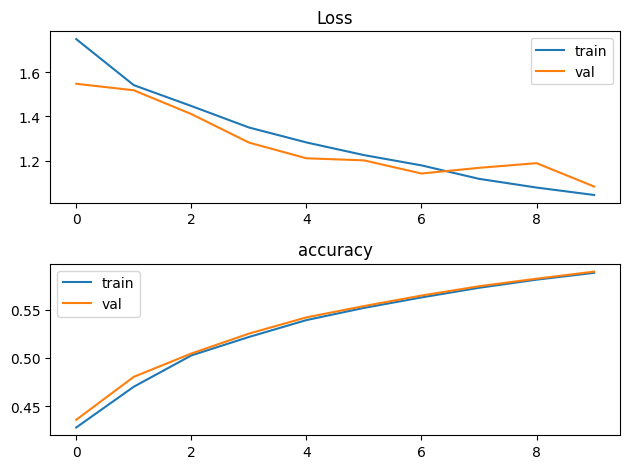

In [11]:
num_epochs = 10
model_name = 'custom_CNN'

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(model.parameters(), lr=0.01)

custom_train_history, custom_val_history = train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

## Testing

In [13]:
# Display the confusion matrix exactly as received from the sklearn library
def display_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(12, 12))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # We will have at most 33 classes
    plt.xticks(range(0, 32))
    plt.yticks(range(0, 32))
    # The padding should be set to 0
    plt.gca().set_xticklabels([str(x) for x in range(1, 33)])
    plt.gca().set_yticklabels([str(x) for x in range(1, 33)])
    plt.show()

def buildConfusionMatrix(preds, labels):
    # We will build our custom confusion matrix with 32 classes
    confusion_matrix = np.zeros((32, 32))
    for i in range(len(preds)):
        confusion_matrix[labels[i]-1, preds[i]-1] += 1
    return confusion_matrix

100%|██████████| 31/31 [00:41<00:00,  1.32s/it]



Test Loss: 1.046 
Test Accuracy: 0.678

[[331.  76.   2. ...   0.   0.   0.]
 [ 49. 314.   2. ...   0.   0.   0.]
 [ 13.  32.   3. ...   0.   0.   0.]
 ...
 [  0.   2.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   2.   0. ...   0.   0.   0.]]


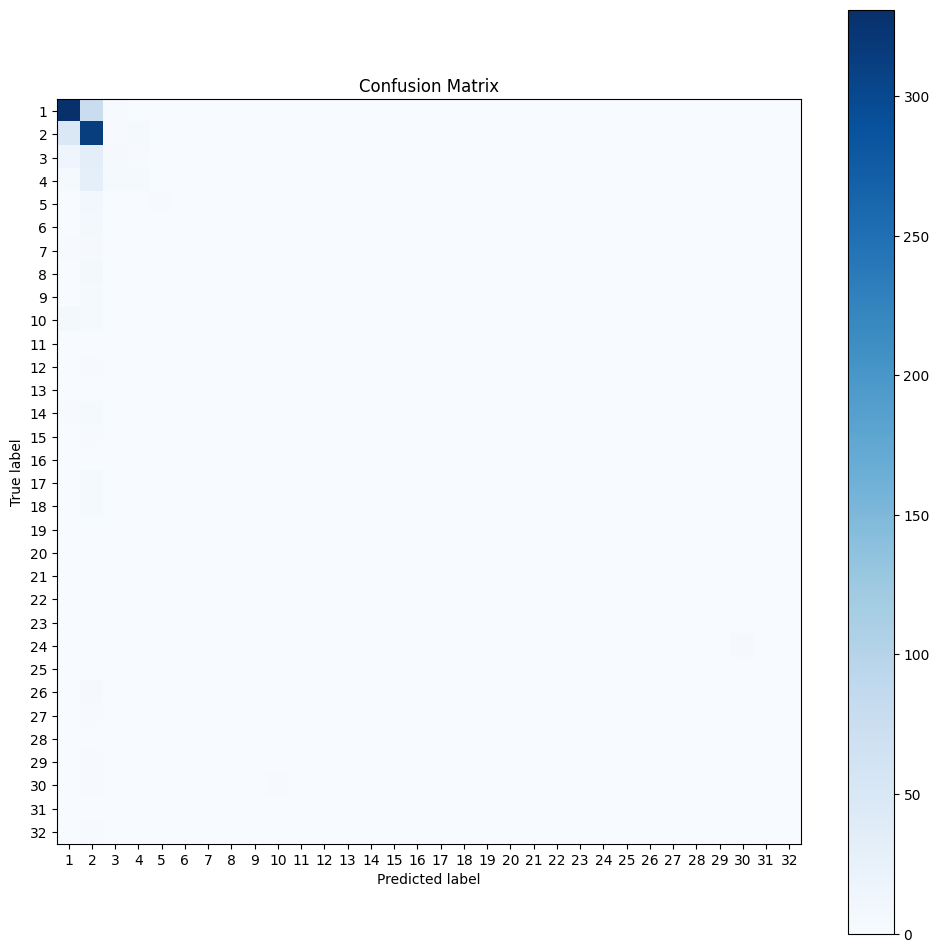

In [13]:
# Load model
model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load(DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')
model.load_state_dict(checkpoint['model'])

# Test model
preds = []
labels = []
test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False, preds=preds, labels=labels)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}\n")

# There predictions and labels are in the range [0, 31], so we need to add 1 to each value
preds = [x+1 for x in preds]
labels = [x+1 for x in labels]

# Confusion matrix with the number in each cell
confusion_matrix = buildConfusionMatrix(preds, labels)
print(confusion_matrix)
# Display confusion matrix
display_confusion_matrix(confusion_matrix)


In [14]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= num_examples: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
      
    plt.show()
    
# showErrors(model, test_dataloader)

## Pre-trained model

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.9/models.html)


In [ ]:
vgg = models.vgg16(pretrained=True)
# set out_features of the last layer to 32
vgg.classifier[6] = nn.Linear(4096, 32)
vgg.to(device)

print(vgg)

# Train network for 5 epochs
num_epochs = 5
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=0.01)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)


In [ ]:
# Load model checkpoint
vgg = models.vgg16(pretrained=True)
vgg.classifier[6] = nn.Linear(4096, 32)
vgg.to(device)

checkpoint = torch.load(DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')
vgg.load_state_dict(checkpoint['model'])

# Test model
preds = []
labels = []

test_loss, test_acc = epoch_iter(test_dataloader, vgg, loss_fn, is_train=False, preds=preds, labels=labels)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}\n")

preds = [x+1 for x in preds]
labels = [x+1 for x in labels]

# Confusion matrix with the number in each cell
confusion_matrix = buildConfusionMatrix(preds, labels)
print(confusion_matrix)
# Display confusion matrix
display_confusion_matrix(confusion_matrix)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Train loss: 2.544 	 Train acc: 0.357


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Val loss: 2.136 	 Val acc: 0.347

Epoch 2


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Train loss: 1.448 	 Train acc: 0.442


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Val loss: 1.400 	 Val acc: 0.468

Epoch 3


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Train loss: 1.065 	 Train acc: 0.527


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Val loss: 1.482 	 Val acc: 0.522
Finished


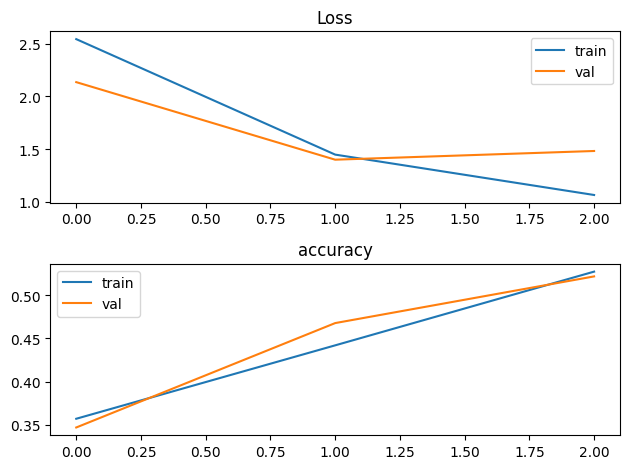

In [15]:
# Try with ResNet
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512, 32)
resnet.to(device)

print(resnet)

# Train network for n epochs
num_epochs = 50
model_name = 'resnet18'

loss_fn = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=0.01)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

In [ ]:
# Load model checkpoint
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512, 32)
resnet.to(device)

checkpoint = torch.load(DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')
resnet.load_state_dict(checkpoint['model'])

# Test model
preds = []
labels = []

test_loss, test_acc = epoch_iter(test_dataloader, resnet, loss_fn, is_train=False, preds=preds, labels=labels)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}\n")

preds = [x+1 for x in preds]
labels = [x+1 for x in labels]

# Confusion matrix with the number in each cell
confusion_matrix = buildConfusionMatrix(preds, labels)
print(confusion_matrix)
# Display confusion matrix
display_confusion_matrix(confusion_matrix)

Now, instead of using 32 classes, we will treat this problem as a regression problem. We will use the same architecture as before, but we will change the output layer to have only one neuron.

In the regression, there we shouldn't reduce the labels by 1, since it's a regression task, so we can use the original labels.

In [ ]:
train_images = [img[0] for img in train_imgs]
train_labels = [img[1] for img in train_imgs]
val_images = [img[0] for img in val_imgs]
val_labels = [img[1] for img in val_imgs]
test_images = [img[0] for img in test_imgs]
test_labels = [img[1] for img in test_imgs]

batch_size = 32 # how many images are processed at a time
num_workers = 4 # how many processes are used to load the data

# Define transformations
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset objects
training_data = CustomDataset(train_images, train_labels, transform=data_aug)
validation_data = CustomDataset(val_images, val_labels, transform=data_aug)
testing_data = CustomDataset(test_images, test_labels, transform=data_aug)

# Define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Show one image
# plt.imshow(training_data[0][0][0,:,:], cmap='gray')

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

7
2
2


In [ ]:
# We need to change the epoch_iter to adapt to the regression problem instead of classification

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True, preds=[], labels=[]):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)
    
    if num_batches == 0:
      print("No data in the dataloader")
      return 0.0, 0.0

    if is_train:
      model.train()
    else:
      model.eval()

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          y = y.float()

          # Obtain prediction
          pred = model(X)
          
          # Obtain loss value
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Calculate final prediction
          preds.extend(pred.cpu().detach().numpy())
          labels.extend(y.cpu().detach().numpy())

    return total_loss / num_batches

In [ ]:
# We also need to change the train function to adapt to the regression problem

def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    
    train_history = {'loss': [], 'mse': []}
    val_history = {'loss': [], 'mse': []}
    
    best_val_loss = np.inf
    
    print("Start training...")
    
    for t in range(num_epochs):
        
        print(f"\nEpoch {t+1}")
        
        train_loss = epoch_iter(train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f}\t")
        
        if(train_loss > 0):
            val_loss = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        else :
            val_loss = 0
            
        print(f"Val loss: {val_loss:.3f} \t")
    
        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')
    
        # save latest model
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, DRIVE_ROOT_DIR + "models/" + model_name + '_latest_model.pth')
    
        # save training history for plotting purposes
        train_history["loss"].append(train_loss)
    
        val_history["loss"].append(val_loss)
        
    print("Finished")
    return train_history, val_history

RegressionVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

100%|██████████| 7/7 [02:19<00:00, 19.90s/it]


Train loss: 48.887	


100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


Val loss: 108.299 	

Epoch 2


100%|██████████| 7/7 [02:17<00:00, 19.62s/it]


Train loss: 56.894	


100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


Val loss: 19.216 	

Epoch 3


100%|██████████| 7/7 [02:14<00:00, 19.20s/it]


Train loss: 49.059	


100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Val loss: 15.709 	

Epoch 4


100%|██████████| 7/7 [02:16<00:00, 19.48s/it]


Train loss: 59.301	


100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


Val loss: 19.635 	

Epoch 5


100%|██████████| 7/7 [02:12<00:00, 18.92s/it]


Train loss: 47.600	


100%|██████████| 2/2 [00:10<00:00,  5.10s/it]


Val loss: 19.200 	
Finished


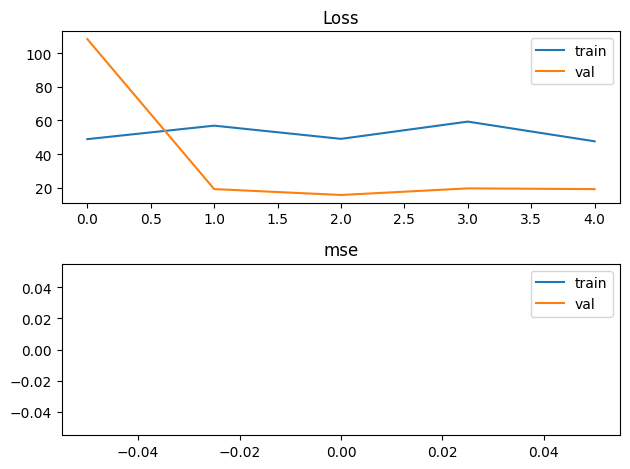

In [ ]:
# Now, use a regression model to predict the number of legos in the image. Use VGG16

class RegressionVGG16(nn.Module):
    def __init__(self):
        super(RegressionVGG16, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.vgg(x)
    
model = RegressionVGG16().to(device)
print(model)

# Train network for 5 epochs
num_epochs = 10
model_name = 'vgg16_regression'

loss_fn = nn.MSELoss()
optimizer_vgg = torch.optim.SGD(model.parameters(), lr=0.001)

vgg_train_history, vgg_val_history = train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history, stat='mse')

100%|██████████| 2/2 [00:10<00:00,  5.37s/it]
/tmp/ipykernel_26698/2052017520.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{preds[i]} {int(preds[i])} | {labels[i]},\t", end='')
/tmp/ipykernel_26698/2052017520.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds = [round(float(pred))for pred in preds]



Test Loss: 8.237 

[1.1117697] 1 | 1.0,	[1.2157933] 1 | 1.0,	[1.1271598] 1 | 2.0,	[0.87557065] 0 | 2.0,	
[1.2621002] 1 | 1.0,	[0.72557855] 0 | 1.0,	[0.53387135] 0 | 1.0,	[1.0227749] 1 | 8.0,	
[0.79581213] 0 | 18.0,	[1.2710145] 1 | 2.0,	[1.034588] 1 | 3.0,	[0.85357934] 0 | 2.0,	
[1.2376949] 1 | 2.0,	[0.92114615] 0 | 2.0,	[1.2461452] 1 | 1.0,	[1.1427402] 1 | 1.0,	
[1.2541769] 1 | 4.0,	[1.1636269] 1 | 3.0,	[1.059234] 1 | 2.0,	[1.062945] 1 | 2.0,	
[1.1892103] 1 | 2.0,	[1.3027754] 1 | 2.0,	[1.2591932] 1 | 2.0,	[1.0882896] 1 | 2.0,	
[1.2959163] 1 | 1.0,	[0.81045985] 0 | 3.0,	[0.8316162] 0 | 2.0,	[1.0496373] 1 | 11.0,	
[0.66607726] 0 | 1.0,	[0.3718275] 0 | 1.0,	[1.2491214] 1 | 1.0,	[0.825168] 0 | 1.0,	
[1.1314474] 1 | 1.0,	[1.0436891] 1 | 1.0,	[0.75677454] 0 | 2.0,	[1.2499447] 1 | 1.0,	
[1.2242178] 1 | 1.0,	[0.99881494] 0 | 1.0,	[1.2686944] 1 | 3.0,	[1.1166043] 1 | 5.0,	
[1.2529604] 1 | 2.0,	[0.99342746] 0 | 2.0,	[1.187028] 1 | 2.0,	[1.1784885] 1 | 1.0,	
[1.0877075] 1 | 2.0,	HEy
[array([1.11

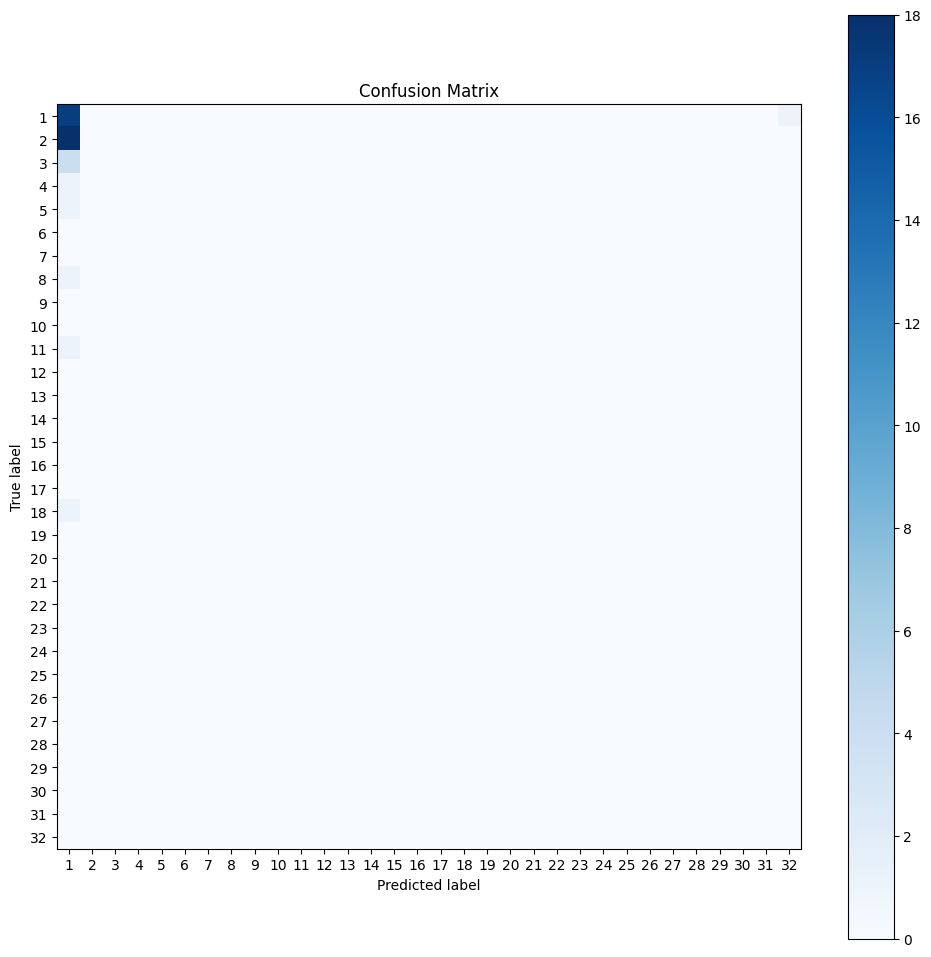

Number of errors: 28
Total number of images: 45
1 | 1,	
1 | 1,	
1 | 2,	
1 | 2,	
1 | 1,	
1 | 1,	
1 | 1,	
1 | 8,	
1 | 18,	
1 | 2,	
1 | 3,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 1,	
1 | 1,	
1 | 4,	
1 | 3,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 1,	
1 | 3,	
1 | 2,	
1 | 11,	
1 | 1,	
0 | 1,	
1 | 1,	
1 | 1,	
1 | 1,	
1 | 1,	
1 | 2,	
1 | 1,	
1 | 1,	
1 | 1,	
1 | 3,	
1 | 5,	
1 | 2,	
1 | 2,	
1 | 2,	
1 | 1,	
1 | 2,	


In [ ]:
# Testing
model = RegressionVGG16().to(device)
checkpoint = torch.load(DRIVE_ROOT_DIR + "models/" + model_name + '_best_model.pth')
model.load_state_dict(checkpoint['model'])

# Test model
preds = []
labels = []
test_loss = epoch_iter(test_dataloader, model, loss_fn, is_train=False, preds=preds, labels=labels)
print(f"\nTest Loss: {test_loss:.3f} \n")


for i in range(len(preds)):
    print(f"{preds[i]} {int(preds[i])} | {labels[i]},\t", end='')
    if (i+1) % 4 == 0:
        print()

print(preds)
print(labels)

# Convert the predictions to integers
preds = [round(float(pred))for pred in preds]
labels = [round(float(label)) for label in labels]

# Confusion matrix with the number in each cell
confusion_matrix = buildConfusionMatrix(preds, labels)
print(confusion_matrix)
# Display confusion matrix
display_confusion_matrix(confusion_matrix)

# Print How many errors we have
errors = 0
for i in range(len(preds)):
    if preds[i] != labels[i]:
        errors += 1
print(f"Number of errors: {errors}")
print(f"Total number of images: {len(preds)}")

# Show some prediction errors
for i in range(len(preds)):
    print(f"{preds[i]} | {labels[i]},\t")